# Load Data

In [1]:
import pickle
import sys
import time 
import numpy as np
import transforms3d as tf3d

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

dataset="1"
cfile = "./data/trainset/cam/cam" + dataset + ".p"
ifile = "./data/trainset/imu/imuRaw" + dataset + ".p"
vfile = "./data/trainset/vicon/viconRot" + dataset + ".p"
ts = tic()
# camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)
toc(ts,"Data import")

Data import took: 0.019115924835205078 sec.



# IMU Calibration

In [2]:
imud_vals = imud['vals'].transpose().reshape(-1,6)
# change imud_vals to int16
imud_vals = imud_vals.astype('int16')
imud_ts = imud['ts'].reshape(-1,1)
initial_time = imud_ts[0]
imud_ts = imud_ts - initial_time
print("imu vals shape: ", imud_vals.shape)
print("imu ts shape: ", imud_ts.shape)

imu vals shape:  (5645, 6)
imu ts shape:  (5645, 1)


In [3]:
imud_vals[0]

array([511, 501, 605, 370, 374, 376], dtype=int16)

In [4]:
def read_imu_data(imu_data):
    # Splitting the matrix into acceleration and angular rate components
    acceleration = imu_data[:, :3]
    angular_rate = imu_data[:, [4, 5, 3]]  # Reordering to Wx, Wy, Wz
    # Correcting the sign due to device design flip
    acceleration[:, 0] = acceleration[:, 0]
    acceleration[:, 1] = acceleration[:, 1]
    acceleration[:, 2] = -acceleration[:, 2]
    return acceleration, angular_rate

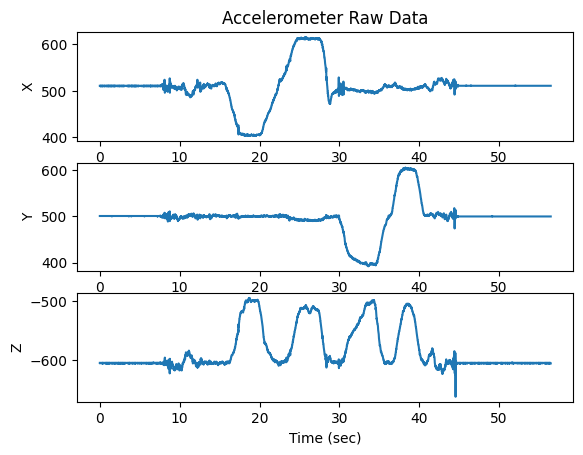

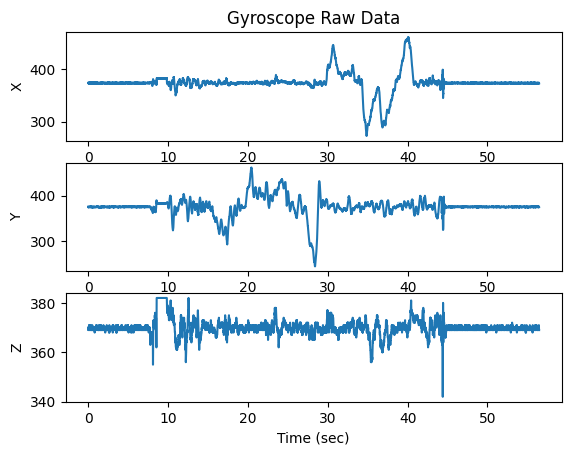

In [5]:
# Plotting the raw data to calculate the bias
import matplotlib.pyplot as plt

acc_raw, gyro_raw = read_imu_data(imud_vals)
# Plot each axis of the accelerometer
acc_X = acc_raw[:, 0]
acc_Y = acc_raw[:, 1]
acc_Z = acc_raw[:, 2]
# Plot each axis of the accelerometer
plt.subplot(3, 1, 1)
plt.plot(imud_ts, acc_X)
plt.ylabel('X')
plt.title('Accelerometer Raw Data')
plt.subplot(3, 1, 2)
plt.plot(imud_ts, acc_Y)
plt.ylabel('Y')
plt.subplot(3, 1, 3)
plt.plot(imud_ts, acc_Z)
plt.ylabel('Z')
plt.xlabel('Time (sec)')
plt.show()

# Plot each axis of the gyroscope
gyro_X = gyro_raw[:, 0]
gyro_Y = gyro_raw[:, 1]
gyro_Z = gyro_raw[:, 2]
plt.subplot(3, 1, 1)
plt.plot(imud_ts, gyro_X)
plt.ylabel('X')
plt.title('Gyroscope Raw Data')
plt.subplot(3, 1, 2)
plt.plot(imud_ts, gyro_Y)
plt.ylabel('Y')
plt.subplot(3, 1, 3)
plt.plot(imud_ts, gyro_Z)
plt.ylabel('Z')
plt.xlabel('Time (sec)')
plt.show()

In [6]:
def convert_raw_to_physical(raw, sensitivity, Vref=3300, bias=0, is_gyro=False):
    scale_factor = Vref / 1023 / sensitivity
    if is_gyro:
        # Convert to radians/sec for gyro
        physical_values = (raw - bias) * scale_factor * np.pi / 180
    else:
        # Convert to g for accelerometer
        physical_values = (raw - bias) * scale_factor

    return physical_values

In [7]:
# Use first 100 samples of X to calculate the bias
acc_bias_X = np.mean(acc_X[:100]) # 0.0
acc_bias_Y = np.mean(acc_Y[:100]) # 0.0
scale_factor = 3300 / 1023 / 300
acc_bias_Z = np.mean(acc_Z[:100]) + 1.0 / scale_factor
gyro_bias_X = np.mean(gyro_X[:100]) # 0.0
gyro_bias_Y = np.mean(gyro_Y[:100]) # 0.0
gyro_bias_Z = np.mean(gyro_Z[:100]) # 0.0
print('Accelerometer bias (g):')
print('X: ', acc_bias_X)
print('Y: ', acc_bias_Y)
print('Z: ', acc_bias_Z)
print('Gyroscope bias (deg/sec):')
print('X: ', gyro_bias_X)
print('Y: ', gyro_bias_Y)
print('Z: ', gyro_bias_Z)

Accelerometer bias (g):
X:  510.79
Y:  501.0
Z:  -512.13
Gyroscope bias (deg/sec):
X:  373.63
Y:  375.2
Z:  369.66


In [8]:
# Converting the raw IMU data to physical values
acc = np.zeros((len(imud_ts), 3))
gyro = np.zeros((len(imud_ts), 3))
acc[:,0] = convert_raw_to_physical(acc_X, 300, Vref=3300, bias=acc_bias_X)
acc[:,1] = convert_raw_to_physical(acc_Y, 300, Vref=3300, bias=acc_bias_Y)
acc[:,2] = convert_raw_to_physical(acc_Z, 300, Vref=3300, bias=acc_bias_Z)
gyro[:,0] = convert_raw_to_physical(gyro_X, 3.33, Vref=3300, bias=gyro_bias_X, is_gyro=True)
gyro[:,1] = convert_raw_to_physical(gyro_Y, 3.33, Vref=3300, bias=gyro_bias_Y, is_gyro=True)
gyro[:,2] = convert_raw_to_physical(gyro_Z, 3.33, Vref=3300, bias=gyro_bias_Z, is_gyro=True)

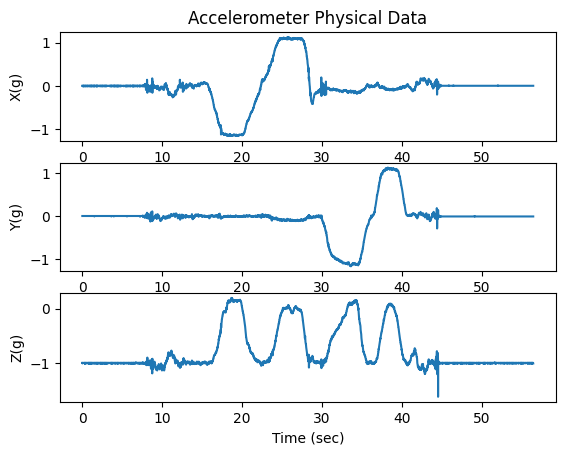

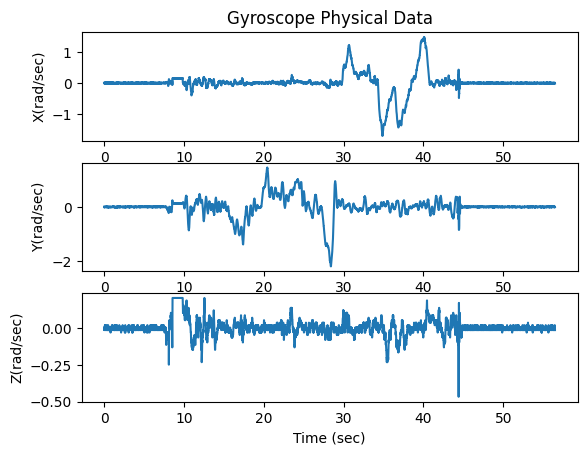

In [9]:
# Plotting the physical data
# Plot each axis of the accelerometer
acc_X = acc[:, 0]
acc_Y = acc[:, 1]
acc_Z = acc[:, 2]
plt.subplot(3, 1, 1)
plt.plot(imud_ts, acc_X)
plt.ylabel('X(g)')
plt.title('Accelerometer Physical Data')
plt.subplot(3, 1, 2)
plt.plot(imud_ts, acc_Y)
plt.ylabel('Y(g)')
plt.subplot(3, 1, 3)
plt.plot(imud_ts, acc_Z)
plt.ylabel('Z(g)')
plt.xlabel('Time (sec)')
plt.show()

# Plot each axis of the gyroscope
gyro_X = gyro[:, 0]
gyro_Y = gyro[:, 1]
gyro_Z = gyro[:, 2]
plt.subplot(3, 1, 1)
plt.plot(imud_ts, gyro_X)
plt.ylabel('X(rad/sec)')
plt.title('Gyroscope Physical Data')
plt.subplot(3, 1, 2)
plt.plot(imud_ts, gyro_Y)
plt.ylabel('Y(rad/sec)')
plt.subplot(3, 1, 3)
plt.plot(imud_ts, gyro_Z)
plt.ylabel('Z(rad/sec)')
plt.xlabel('Time (sec)')
plt.show()

# Simple Intergration and Comparison

In [10]:
# calculate imu estimation pose
q_imu = tf3d.quaternions.np.array([1, 0, 0, 0])
q_imu_list = []
for i in range(len(imud_ts)):
    if i == 0:
        q_imu_list.append(q_imu)
        continue
    else:
        time_elapsed = (imud_ts[i] - imud_ts[i-1])[0]
        q_omega_tau = tf3d.quaternions.np.array([0, gyro[i-1, 0] * time_elapsed / 2, gyro[i-1, 1] * time_elapsed / 2, gyro[i-1, 2] * time_elapsed / 2])
        q_imu = tf3d.quaternions.qmult(q_imu, tf3d.quaternions.qexp(q_omega_tau))
        q_imu_list.append(q_imu)
        
imu_yaw = np.zeros(len(imud_ts))
imu_pitch = np.zeros(len(imud_ts))
imu_roll = np.zeros(len(imud_ts))
for i in range(len(imud_ts)):
    imu_yaw[i], imu_pitch[i], imu_roll[i] = tf3d.euler.quat2euler(q_imu_list[i], axes='sxyz')

In [11]:
# calculate vicon pose
vicd_vals = vicd['rots'].reshape(3,3,-1)
vicd_vals = vicd_vals.transpose(2,0,1)

vicd_ts = vicd['ts'].reshape(-1,1)
vicd_ts = vicd_ts - initial_time
print("vicon vals shape: ", vicd_vals.shape)
print("vicon ts shape: ", vicd_ts.shape)

vicd_yaw = np.zeros((len(vicd_ts), 1))
vicd_pitch = np.zeros((len(vicd_ts), 1))
vicd_roll = np.zeros((len(vicd_ts), 1))

for i in range(len(vicd_ts)):
    R = vicd_vals[i]
    euler = tf3d.euler.mat2euler(R)
    vicd_yaw[i] = euler[0]
    vicd_pitch[i] = euler[1]
    vicd_roll[i] = euler[2]

vicon vals shape:  (5561, 3, 3)
vicon ts shape:  (5561, 1)


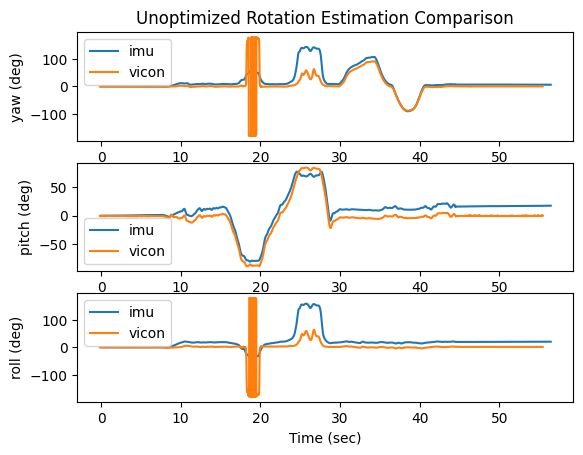

In [12]:
# compare yaw pitch roll
plt.subplot(3, 1, 1)
plt.plot(imud_ts, imu_yaw/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_yaw/np.pi*180, label='vicon')
plt.ylabel('yaw (deg)')
plt.title('Unoptimized Rotation Estimation Comparison')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(imud_ts, imu_pitch/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_pitch/np.pi*180, label='vicon')
plt.ylabel('pitch (deg)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(imud_ts, imu_roll/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_roll/np.pi*180, label='vicon')
plt.ylabel('roll (deg)')
plt.legend()
plt.xlabel('Time (sec)')
plt.show()

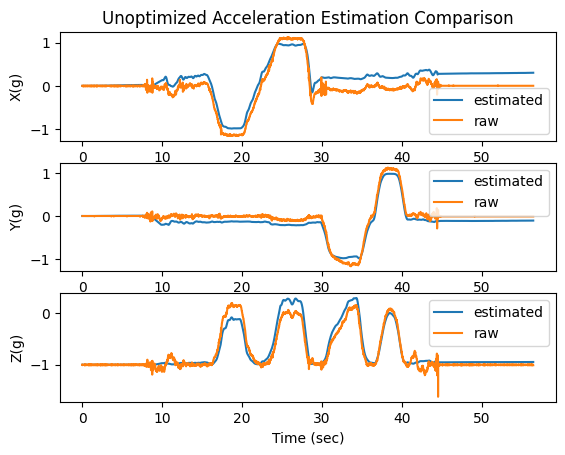

In [13]:
# calculate estimated acceleration
acc_est = np.zeros((len(imud_ts), 3))
for i in range(len(imud_ts)):
    acc_init = tf3d.quaternions.np.array([0, 0, 0, -1])
    acc_iter = tf3d.quaternions.qmult(tf3d.quaternions.qmult(tf3d.quaternions.qinverse(q_imu_list[i]), acc_init), q_imu_list[i])
    acc_est[i] = acc_iter[1:]

# compare estimated acceleration with raw acceleration
plt.subplot(3, 1, 1)
plt.plot(imud_ts, acc_est[:,0], label='estimated')
plt.plot(imud_ts, acc[:,0], label='raw')
plt.ylabel('X(g)')
plt.title('Unoptimized Acceleration Estimation Comparison')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(imud_ts, acc_est[:,1], label='estimated')
plt.plot(imud_ts, acc[:,1], label='raw')
plt.ylabel('Y(g)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(imud_ts, acc_est[:,2], label='estimated')
plt.plot(imud_ts, acc[:,2], label='raw')
plt.ylabel('Z(g)')
plt.legend()
plt.xlabel('Time (sec)')
plt.show()

# Optimization

In [14]:
import jax.numpy as jnp

def qexp_batched(q):
    qs, qv = q[..., 0], q[..., 1:]
    norm_qv = jnp.linalg.norm(qv, axis=-1, keepdims=True)
    scalar = jnp.exp(qs)
    vec = jnp.where(norm_qv > 0, (qv / norm_qv) * jnp.sin(norm_qv), qv)
    return jnp.concatenate([scalar[..., None] * jnp.cos(norm_qv), scalar[..., None] * vec], axis=-1)

def qlog_batched(q):
    qs, qv = q[..., 0], q[..., 1:]
    norm_q = jnp.linalg.norm(q, axis=-1)
    norm_qv = jnp.linalg.norm(qv, axis=-1)
    cos_term = jnp.clip(qs / norm_q, -1, 1)
    vec = jnp.where(
        norm_qv[..., None] > 0,
        (qv / norm_qv[..., None]) * jnp.arccos(cos_term)[..., None],
        qv
    )
    return jnp.concatenate([jnp.log(norm_q)[..., None], vec], axis=-1)

def qinverse_batched(q):
    w, x, y, z = q[..., 0], q[..., 1], q[..., 2], q[..., 3]
    norm_squared = jnp.sum(q * q, axis=-1, keepdims=True)
    return jnp.stack([w, -x, -y, -z], axis=-1) / norm_squared

def qmult_batched(q1, q2):
    w1, x1, y1, z1 = q1[..., 0], q1[..., 1], q1[..., 2], q1[..., 3]
    w2, x2, y2, z2 = q2[..., 0], q2[..., 1], q2[..., 2], q2[..., 3]

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return jnp.stack([w, x, y, z], axis=-1)
# loss function
def loss_function(q_imu, acc):
    global imud_ts, gyro
    # Batched version of the motion error
    motion_error = 0
    q1 = q_imu[:-1]
    q2 = q_imu[1:]
    time_elapsed = (imud_ts[1:] - imud_ts[:-1])[:, 0]
    q_omega_tau = jnp.stack([jnp.zeros_like(time_elapsed), gyro[:-1, 0] * time_elapsed / 2, gyro[:-1, 1] * time_elapsed / 2, gyro[:-1, 2] * time_elapsed / 2], axis=-1)
    q2 = qmult_batched(q2, qexp_batched(q_omega_tau))
    q1_inv_q2 = qmult_batched(qinverse_batched(q1), q2)
    q1_inv_q2 = jnp.round(q1_inv_q2, 8)
    motion_error = jnp.sum(jnp.linalg.norm(2 * qlog_batched(q1_inv_q2), axis=-1)**2)
    
    # # Batched version of the observation error
    observation_error = 0
    q = q_imu[1:]
    a = acc[1:]
    g = jnp.array([0, 0, 0, -1.0])
    # observation = qmult_batched(qinverse_batched(q), qmult_batched(g, q))
    observation = qmult_batched(qinverse_batched(q), qmult_batched(g, q))
    observation_error = jnp.sum(jnp.linalg.norm(a - observation[..., 1:], axis=-1)**2)

    print("motion_error: ", motion_error)
    print("observation_error: ", observation_error)
    return 0.5 * motion_error + 0.5 * observation_error

# loss function
def part_loss_function(q_imu, acc):
    global imud_ts, gyro
    # Batched version of the motion error
    motion_error = 0
    q1 = q_imu[:-1]
    q2 = q_imu[1:]
    time_elapsed = (imud_ts[1:] - imud_ts[:-1])[:, 0]
    q_omega_tau = jnp.stack([jnp.zeros_like(time_elapsed), gyro[:-1, 0] * time_elapsed / 2, gyro[:-1, 1] * time_elapsed / 2, gyro[:-1, 2] * time_elapsed / 2], axis=-1)
    q2 = qmult_batched(q2, qexp_batched(q_omega_tau))
    q1_inv_q2 = qmult_batched(qinverse_batched(q1), q2)
    q1_inv_q2 = jnp.round(q1_inv_q2, 8)
    motion_error = jnp.sum(jnp.linalg.norm(2 * qlog_batched(q1_inv_q2), axis=-1)**2)
    
    # # Batched version of the observation error
    observation_error = 0
    q = q_imu[1:]
    a = acc[1:]
    g = jnp.array([0, 0, 0, -1.0])
    # observation = qmult_batched(qinverse_batched(q), qmult_batched(g, q))
    observation = qmult_batched(qinverse_batched(q), qmult_batched(g, q))
    observation_error = jnp.sum(jnp.linalg.norm(a - observation[..., 1:], axis=-1)**2)

    return 0.5 * motion_error, 0.5 * observation_error

In [15]:
from jax import jit, grad, vmap
import jax.numpy as jnp

# Gradient computation
grad_loss = jit(grad(loss_function))

# Helper function to project gradient onto tangent plane of the sphere
def project_onto_tangent_plane(gradient, q_imu):
    # Project the gradient onto the tangent plane at q_imu
    return gradient - q_imu * jnp.dot(q_imu, gradient)

# Optimization process
def optimize_quaternions(q_imu, acc, learning_rate=0.01, num_iterations=100):
    loss_list = []
    for i in range(num_iterations):
        # Compute the gradient
        gradients = grad_loss(q_imu, acc)
        
        # Project the gradient onto the tangent plane of the sphere at q_imu
        tangent_gradients = vmap(project_onto_tangent_plane)(gradients, q_imu)
        
        # Update quaternion parameters with a simple learning rate
        q_imu = q_imu - learning_rate * tangent_gradients
        
        # Renormalize the quaternion to ensure it stays on the unit sphere
        q_imu = q_imu / jnp.linalg.norm(q_imu, axis=1, keepdims=True)
        
        loss = loss_function(q_imu, acc)

        motion_error, observation_error = part_loss_function(q_imu, acc)

        loss_list.append((motion_error, observation_error))

        print('Iteration', i, 'Loss', loss)
    
    return q_imu, loss_list


q_imu_np = np.array(q_imu_list)
acc_np = np.array(acc)
optimized_quaternions, loss_list = optimize_quaternions(q_imu_np, acc_np)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


motion_error:  Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
observation_error:  Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f0bfd7ab290>, in_tracers=(Traced<ShapedArray(float32[5644]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x7f0bfd7b54a0; to 'JaxprTracer' at 0x7f0bfd7b5540>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[5644]. let b:f32[] = reduce_sum[axes=(0,)] a in (b,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False,), 'name': '_reduce_sum', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x

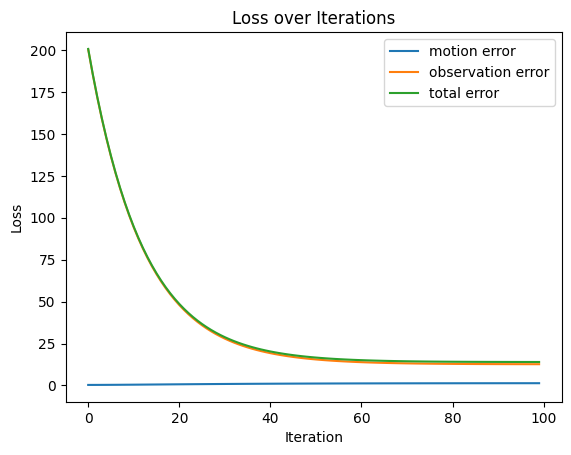

In [16]:
# plot 
loss_list = np.array(loss_list)
plt.plot(loss_list[:,0], label='motion error')
plt.plot(loss_list[:,1], label='observation error')
plt.plot(loss_list[:,0] + loss_list[:,1], label='total error')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

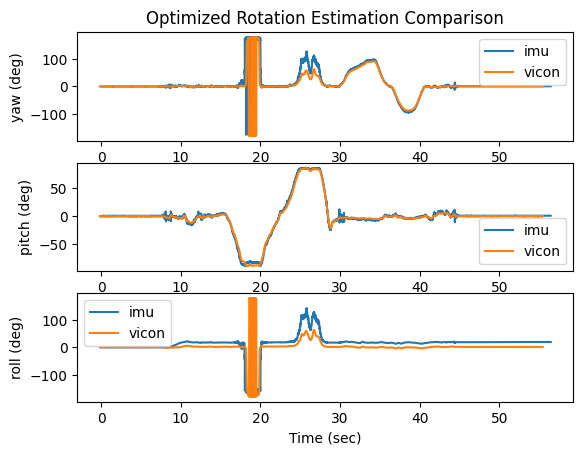

In [17]:
# plot optimized imu pose
imu_yaw = np.zeros(len(imud_ts))
imu_pitch = np.zeros(len(imud_ts))
imu_roll = np.zeros(len(imud_ts))
for i in range(len(imud_ts)):
    imu_yaw[i], imu_pitch[i], imu_roll[i] = tf3d.euler.quat2euler(optimized_quaternions[i], axes='sxyz')

# compare yaw pitch roll
plt.subplot(3, 1, 1)
plt.plot(imud_ts, imu_yaw/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_yaw/np.pi*180, label='vicon')
plt.ylabel('yaw (deg)')
plt.title('Optimized Rotation Estimation Comparison')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(imud_ts, imu_pitch/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_pitch/np.pi*180, label='vicon')
plt.ylabel('pitch (deg)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(imud_ts, imu_roll/np.pi*180, label='imu')
plt.plot(vicd_ts, vicd_roll/np.pi*180, label='vicon')
plt.ylabel('roll (deg)')
plt.legend()
plt.xlabel('Time (sec)')
plt.show()

# Panorama(GT)

In [18]:
camd = read_data(cfile)
image_list = []
for i in range(0, camd['cam'].shape[3]):
  image_list.append(camd['cam'][:,:,:,i])
print("image_list length: ", len(image_list))
print('image size: ', image_list[0].shape)

image_list length:  1685
image size:  (240, 320, 3)


In [19]:
# Use the Vicon data to stitch the images together
camd_ts = camd['ts'].reshape(-1,1)
camd_ts = camd_ts - initial_time
def find_closest_timestamps(camera_ts, vicon_ts):
    indices = []
    for ts in camera_ts:
        # Compute absolute difference
        diff = np.abs(vicon_ts - ts)
        # Find index of the minimum difference
        index = np.argmin(diff)
        indices.append(index)
    return indices

closest_indices = find_closest_timestamps(camd_ts, vicd_ts)
closest_orientations = vicd_vals[closest_indices]

In [20]:
from scipy.spatial.transform import Rotation as R

def image_to_world_coordinates(image, fov, rotation_matrix):
    h_fov, v_fov = np.radians(fov)  # Convert FOV from degrees to radians
    image_height, image_width = image.shape[:2]

    # Generate grid of pixel coordinates
    x_idx, y_idx = np.meshgrid(np.arange(image_width), np.arange(image_height))

    # Convert pixel coordinates to normalized device coordinates (NDC), from -1 to 1
    x_normalized = (x_idx - (image_width / 2)) / (image_width / 2)
    y_normalized = (y_idx - (image_height / 2)) / (image_height / 2)

    # Calculate spherical coordinates
    lambda_ = x_normalized * (h_fov / 2)
    phi_ = y_normalized * (v_fov / 2)

    # Convert spherical to Cartesian coordinates assuming unit sphere (radius = 1)
    x_cartesian = np.cos(phi_) * np.sin(lambda_)
    y_cartesian = np.sin(phi_)
    z_cartesian = np.cos(phi_) * np.cos(lambda_)

    # Stack to create Cartesian coordinate array for each pixel
    cartesian_coordinates = np.stack((x_cartesian, y_cartesian, z_cartesian), axis=-1)

    # Flatten the coordinate array to apply rotation
    cartesian_coordinates_flat = cartesian_coordinates.reshape(-1, 3)

    # Transform image to world coordinates
    camera_to_world = np.array([[0, 0, -1],
                               [1, 0, 0],
                                [0, 1, 0]])
    t = np.array([0, 0, 0.1])
    cartesian_coordinates_flat = np.dot(camera_to_world, cartesian_coordinates_flat.T).T + t

    # Create a rotation object from the rotation matrix
    rotation = R.from_matrix(rotation_matrix)

    # Apply rotation to the Cartesian coordinates
    world_coordinates_flat = rotation.apply(cartesian_coordinates_flat)

    # Reshape back to the original image shape with an additional dimension for the coordinates
    world_coordinates = world_coordinates_flat.reshape(image_height, image_width, 3)

    return world_coordinates

In [21]:
# get all world coordinates
world_coords_list = []
color_list = []
fov = (60, 45)
for i in range(0,len(image_list)):
    world_coords_list.append(image_to_world_coordinates(image_list[i], fov, closest_orientations[i]))
    color_list.append(image_list[i])
world_coords_list = np.array(world_coords_list)
color_list = np.array(color_list)
# view first 
print("world_coords_list shape: ", world_coords_list.shape)
print("color_list shape: ", color_list.shape)

world_coords_list shape:  (1685, 240, 320, 3)
color_list shape:  (1685, 240, 320, 3)


In [22]:
import open3d as o3d
# visualize with color
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(world_coords_list.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(color_list.reshape(-1, 3) / 255)
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [23]:
def world_to_cylinder(world_coords):
    # Extract X, Y, Z coordinates
    X, Y, Z = world_coords[:, 0], world_coords[:, 1], world_coords[:, 2]
    # Calculate cylindrical coordinates
    width = np.arctan2(Y, X)  # Angular coordinate
    width = np.mod(width, 2 * np.pi)
    width = width / (2 * np.pi)

    height = Z / 2 + 0.5
    return width, height

world_coords_flat = world_coords_list.reshape(-1, 3)
color_flat = color_list.reshape(-1, 3)
x_2d, y_2d = world_to_cylinder(world_coords_flat)

In [24]:
# Project to 2D plane
x_res = 3000
y_res = 1000
x_2d = (x_2d * x_res).astype(int)
x_2d = np.clip(x_2d, 0, x_res - 1)
y_2d = (y_2d * y_res).astype(int)
y_2d = np.clip(y_2d, 0, y_res - 1)

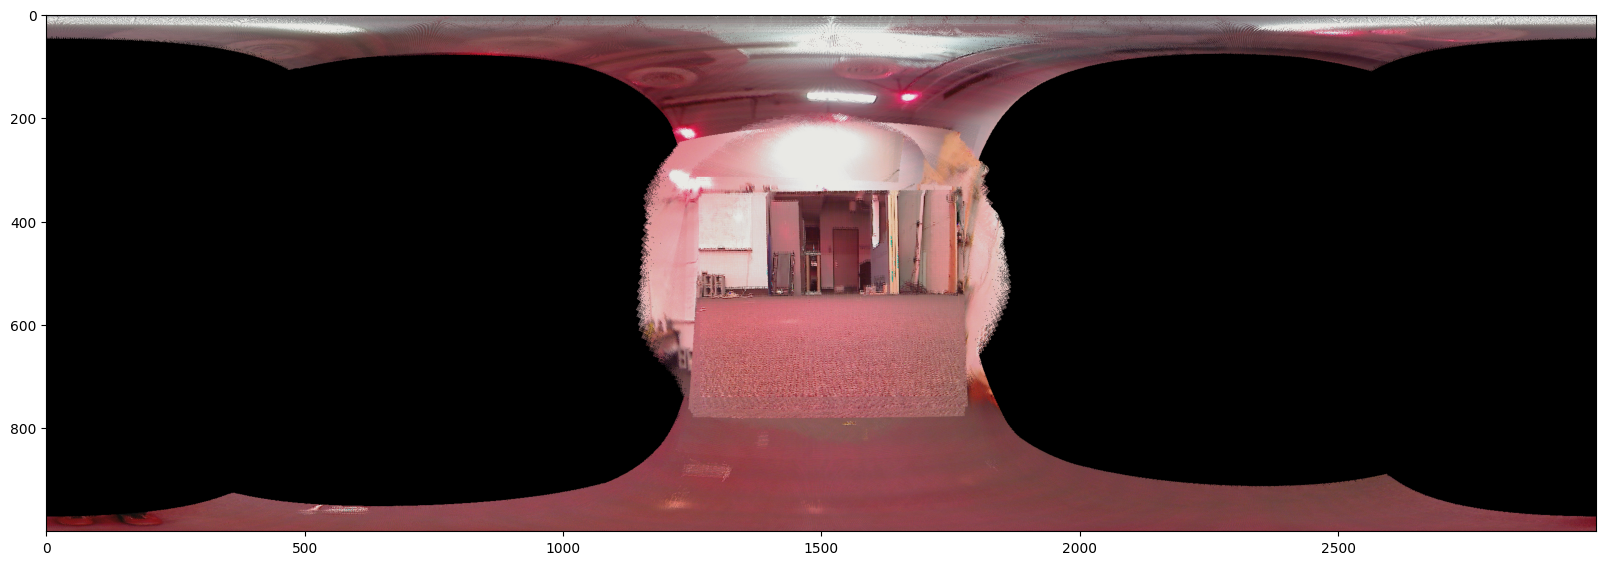

In [25]:
cylinder_image = np.zeros((y_res, x_res, 3), dtype=np.uint8)
cylinder_image[y_2d, x_2d] = color_flat
plt.figure(figsize=(20, 10))
plt.imshow(cylinder_image)
plt.show()

# Panorama(Estimated)

In [26]:
camd = read_data(cfile)
image_list = []
for i in range(0, camd['cam'].shape[3]):
  image_list.append(camd['cam'][:,:,:,i])
print("image_list length: ", len(image_list))
print('image size: ', image_list[0].shape)

image_list length:  1685
image size:  (240, 320, 3)


In [27]:
# Use the Vicon data to stitch the images together
camd_ts = camd['ts'].reshape(-1,1)
camd_ts = camd_ts - initial_time
def find_closest_timestamps(camera_ts, imu_ts):
    indices = []
    for ts in camera_ts:
        # Compute absolute difference
        diff = np.abs(imu_ts - ts)
        # Find index of the minimum difference
        index = np.argmin(diff)
        indices.append(index)
    return indices

imud_rot_list = []
for i in range(len(imud_ts)):
    R = tf3d.quaternions.quat2mat(optimized_quaternions[i, :])
    imud_rot_list.append(R)
imud_rot_list = np.array(imud_rot_list)
closest_indices = find_closest_timestamps(camd_ts, imud_ts)
closest_orientations = imud_rot_list[closest_indices]

In [28]:
from scipy.spatial.transform import Rotation as R

# get all world coordinates
world_coords_list = []
color_list = []
fov = (60, 45)
for i in range(0,len(image_list)):
    world_coords_list.append(image_to_world_coordinates(image_list[i], fov, closest_orientations[i]))
    color_list.append(image_list[i])
world_coords_list = np.array(world_coords_list)
color_list = np.array(color_list)
# view first 
print("world_coords_list shape: ", world_coords_list.shape)
print("color_list shape: ", color_list.shape)

world_coords_list shape:  (1685, 240, 320, 3)
color_list shape:  (1685, 240, 320, 3)


In [29]:
import open3d as o3d
# visualize with color
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(world_coords_list.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(color_list.reshape(-1, 3) / 255)
o3d.visualization.draw_geometries([pcd])

In [30]:
world_coords_flat = world_coords_list.reshape(-1, 3)
color_flat = color_list.reshape(-1, 3)
x_2d, y_2d = world_to_cylinder(world_coords_flat)
# Project to 2D plane
x_res = 3000
y_res = 1000
x_2d = (x_2d * x_res).astype(int)
x_2d = np.clip(x_2d, 0, x_res - 1)
y_2d = (y_2d * y_res).astype(int)
y_2d = np.clip(y_2d, 0, y_res - 1)

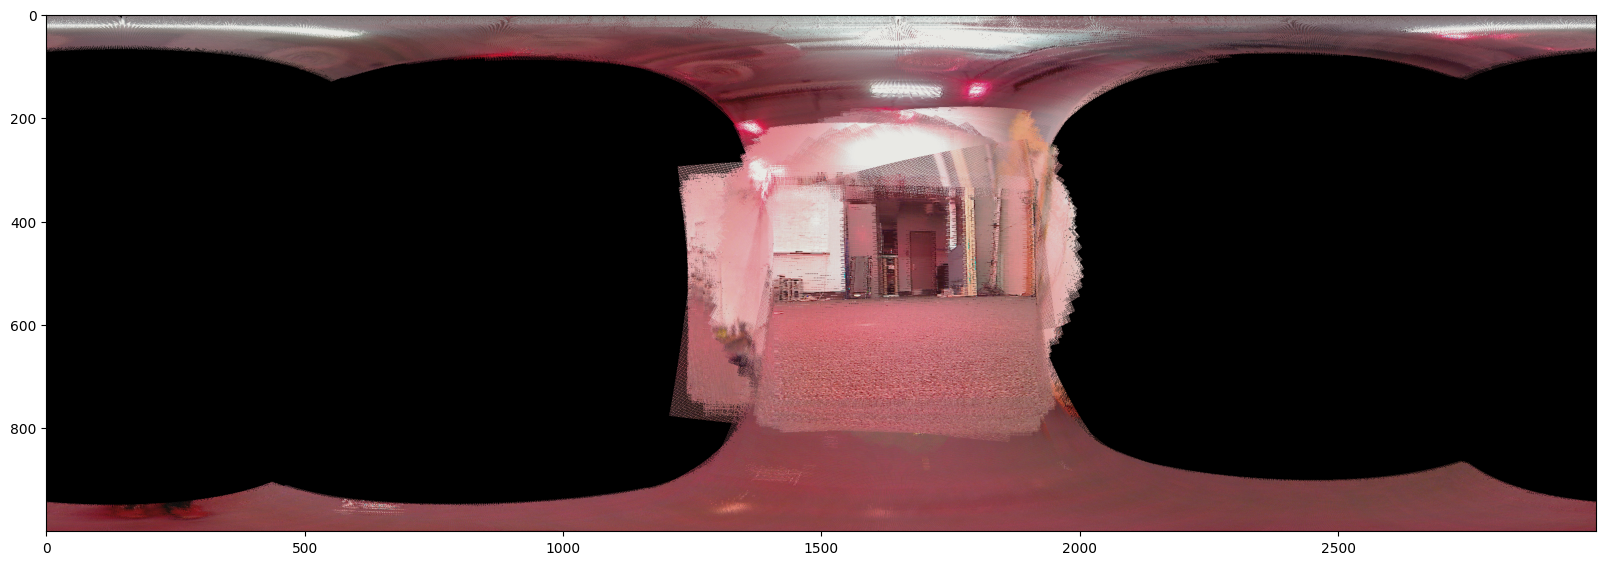

In [31]:
cylinder_image = np.zeros((y_res, x_res, 3), dtype=np.uint8)
cylinder_image[y_2d, x_2d] = color_flat
plt.figure(figsize=(20, 10))
plt.imshow(cylinder_image)
plt.show()